### IMPORT NECESSARY LIBRARIES 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [4]:
df = pd.read_csv('all_stocks_5yr.csv')
df.head(3)

,date,close,Name
0,2/8/2013,14.7500,AAL
1,2/11/2013,14.4600,AAL
2,2/12/2013,14.2700,AAL


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   close   619040 non-null  float64
 2   Name    619040 non-null  object 
dtypes: float64(1), object(2)
memory usage: 14.2+ MB


In [6]:
# convert date column into 'date' format
df.date = pd.to_datetime(df.date)

### BEFORE AUTOMATION  - TRAIN AN LSTM MODEL WITH A SINGLE RANDOMLY CHOSEN STOCK -

In [106]:
#Randomly choose a stock to train the model - let's select 'ADBE'
df1 = df[df['Name']== 'ADBE']

In [107]:
df2 = df1.drop(columns=['Name'])

In [108]:
df2 = df2.set_index('date')
df2.tail(3)

,close
date,
2018-02-05,190.2700
2018-02-06,194.4700
2018-02-07,192.3400


In [15]:
# Create a function to generate dataset for LSTM model
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [75]:
# Prepare the data before establishing the model
dataset = df2.close.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [76]:
# Establish the model
model = Sequential()
model.add(LSTM(64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=500, batch_size=30, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=0)


In [77]:
# Prediction Results
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1,1))
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[0])))

Train Mean Absolute Error: 0.45578384
Train Root Mean Squared Error: 0.45578384
Test Mean Absolute Error: 0.0038833618
Test Root Mean Squared Error: 0.0038833618


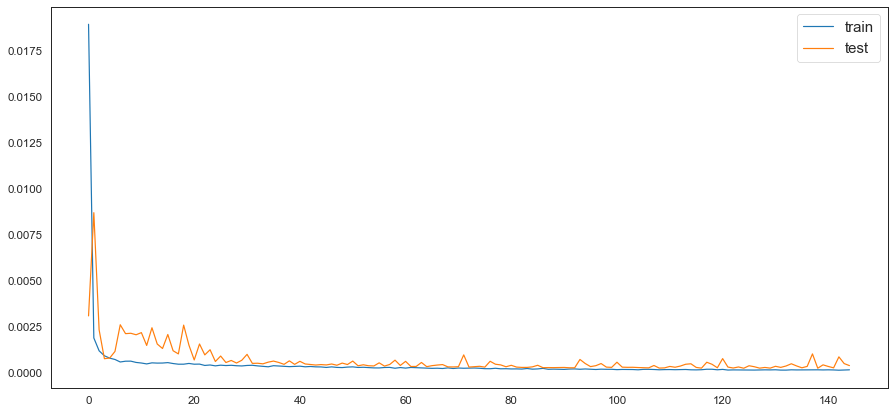

In [78]:
# TRAIN-TEST ERROR ASSESSMENT (It seems model starts to balance its accuracy after ~30th epoch)
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(fontsize=15)

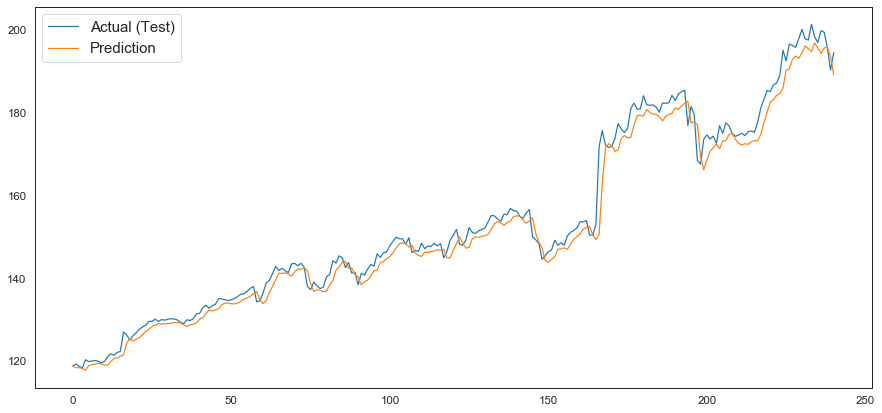

In [79]:
# GRAPH CREATION (test vs trained model) - It seems there is a great fit!
test_actual = pd.DataFrame(Y_test)
test_actual = test_actual.rename(columns={0: 'Actual'})
test_prediction = pd.DataFrame(test_predict)
test_prediction = test_prediction.rename(columns={0: 'Prediction'})
graph =  pd.concat([test_actual, test_prediction], axis=1, sort=False)
# SETTINGS
plt.figure(figsize=(15,7))
plt.plot(graph.Actual,label="Actual (Test)")
plt.plot(graph.Prediction,label="Prediction")
plt.legend(fontsize=15)

In [80]:
### EXAMPLE - HOW TO PREDICT FUTURE? (NEXT 1 DAY)
new = df2.iloc[-look_back:,:]
data_new = scaler.fit_transform(new)
data_new = np.array(data_new)

xyz = np.reshape(data_new, (1, 1, look_back))
xyz = model.predict_on_batch(xyz)
future_prediction = scaler.inverse_transform(xyz)
print(scaler.inverse_transform(data_new)),print(future_prediction)

[[197.51]
 [201.3 ]
 [198.23]
 [196.9 ]
 [199.76]
 [199.38]
 [195.64]
 [190.27]
 [194.47]
 [192.34]]
[[192.64764]]


(None, None)

### AUTOMATION

In [17]:
# AUTOMATION (adjustment 1)

# PERIOD SELECTION FOR TESTS ( let's go ahead with a 2-year data)
# A randomly chosen time frame
start_date = '2015-07-06'
before_prediction_date = '2017-07-06'     # must be same #
target_prediction_day = '2017-07-07'

period_ends = before_prediction_date          # must be same #
prediod_begins = '2017-06-22'

In [18]:
# Data filtering based on the selected date interval
df2 = df[(df.date >= start_date) & (df.date <= target_prediction_day)]
count_of_train_days = df2['date'].nunique()
count_of_train_days

507

In [19]:
# AUTOMATION (adjustment 2)
# This will be a 1 day forward prediction 
train_day_count = count_of_train_days -1
predict_day_count = 1 

In [20]:
# Data Manipulation to 
df3 = df2.pivot(index='date',columns = 'Name', values = 'close')
NAColumns = df3.columns[df3.isna().any()].tolist()
df3 = df3.drop(NAColumns,axis=1)
stock_count = len(df3.columns)
stock_count

491

In [22]:
# PERIOD CHECK (THIS MUST BE EQUAL TO LOOK BACK)
print(df3.loc[prediod_begins:period_ends,:].iloc[:,0])  # only first column 
print(len(df3.loc[prediod_begins:period_ends,]))

date
2017-06-22   60.6100
2017-06-23   59.7700
2017-06-26   59.2400
2017-06-27   58.8800
2017-06-28   59.4000
2017-06-29   58.8000
2017-06-30   59.3100
2017-07-03   59.1300
2017-07-05   59.7700
2017-07-06   59.2200
Name: A, dtype: float64
10


In [23]:
# choose as much stock as you want (lets go ahead with 50 randomly chosen stocks)
df3 = df3.iloc[:,250:300]
df3.tail(3)

Name,JNPR,JPM,JWN,K,KEY,KHC,KIM,KLAC,KMB,KMI,...,MCHP,MCK,MCO,MDLZ,MDT,MET,MGM,MHK,MKC,MLM
date,,,,,,,,,,,,,,,,,,,,,
2017-07-05,28.1800,93.6800,48.1200,67.7000,19.2000,83.7900,17.8500,92.2900,128.6600,19.3100,...,77.9400,165.2700,123.9800,43.1200,88.9000,55.8900,30.9800,243.7600,96.7500,226.8400
2017-07-06,27.7900,93.3800,47.3800,66.5500,19.0000,82.8200,17.9600,92.4800,126.3800,19.1300,...,77.1200,163.0800,122.1700,43.0600,87.2600,55.8800,30.3000,241.6700,95.7400,226.0000
2017-07-07,28.4500,93.8500,47.5400,66.5200,19.2200,83.0400,18.4300,94.5700,126.8000,19.1700,...,78.3600,164.6800,123.4200,43.2200,87.9600,56.1700,30.8400,245.7500,95.7500,227.9000


In [24]:
### FOR LOOP TO POPULATE PREDICTIONS FOR EACH STOCK ###

a = []
upper = len(df3.columns)
for x in range(0,upper):
    
    
    # DATA PREPARATION PHASE
    df6  = pd.DataFrame(df3.iloc[:,x]) ### dataset  = pd.DataFrame(df3.iloc[:,x])
    dataset = df6.iloc[0:train_day_count,:].values ### dataset = dataset1.iloc[:,0].values#numpy.ndarray 
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    train_size = int(len(dataset) * 0.80)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
    # create datasets for model  
    look_back = 10
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # MODEL PHASE
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(X_train, Y_train, epochs=500, batch_size=30, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=0)
    #model.summary()
    
    ### PREDICTION    --- To predict future NEXT 1 DAY) --- new = dataset.iloc[-look_back:,:]
    new = df6.loc[prediod_begins:period_ends,:]
    data_new = scaler.fit_transform(new)
    data_new = np.array(data_new)

    xyz = np.reshape(data_new, (1, 1, look_back))
    xyz = model.predict_on_batch(xyz)
    future_prediction = scaler.inverse_transform(xyz)
    
    ### POPULATING RESULTS
    a.append(future_prediction)

In [25]:
### Convert predictions into dataframe format
a = np.array(a)
a = a.flatten() 
a = pd.DataFrame(a)
b = a.iloc[:,-1]
b = b.values.tolist()
prediction = pd.DataFrame(b,columns= ["Predictions"])
prediction.head(3)

,Predictions
0,27.8911
1,93.5290
2,47.5791


In [26]:
### Create Actuals (t) to make a performance assessment
actuals  = df3.reset_index()[df3.reset_index()['date'] == target_prediction_day]
actuals  = actuals.melt(id_vars = 'date')
actuals = actuals.rename(columns={'value': 'Actual Day'})
actuals.head(3)

,date,Name,Actual Day
0,2017-07-07,JNPR,28.4500
1,2017-07-07,JPM,93.8500
2,2017-07-07,JWN,47.5400


In [27]:
### Create Actuals (t-1) to make a performance assessment
previous  = df3.reset_index()[df3.reset_index()['date'] == period_ends]
previous  = previous.melt(id_vars = 'date')
previous = previous.rename(columns={'value': 'Previous Day'})
previous.head(3)

,date,Name,Previous Day
0,2017-07-06,JNPR,27.7900
1,2017-07-06,JPM,93.3800
2,2017-07-06,JWN,47.3800


In [28]:
# Combine t & t-1
combined = previous.merge(actuals, left_on='Name', right_on='Name')
combined = combined.drop('date_y',axis=1)
combined =  pd.concat([combined, prediction], axis=1, sort=False)
combined.head(3)

,date_x,Name,Previous Day,Actual Day,Predictions
0,2017-07-06,JNPR,27.7900,28.4500,27.8911
1,2017-07-06,JPM,93.3800,93.8500,93.5290
2,2017-07-06,JWN,47.3800,47.5400,47.5791


In [29]:
# Combine dataframes
Actual_Change = ((combined["Actual Day"] - combined["Previous Day"]) / (combined["Previous Day"])) * 100
combined["Actual Change %"] = Actual_Change
Predicted_Change = ((combined["Predictions"] - combined["Previous Day"]) / (combined["Previous Day"])) * 100
combined["Predicted Change %"] = Predicted_Change

In [30]:
combined.head(3)

,date_x,Name,Previous Day,Actual Day,Predictions,Actual Change %,Predicted Change %
0,2017-07-06,JNPR,27.7900,28.4500,27.8911,2.3750,0.3638
1,2017-07-06,JPM,93.3800,93.8500,93.5290,0.5033,0.1596
2,2017-07-06,JWN,47.3800,47.5400,47.5791,0.3377,0.4203


In [31]:
# Accuracy Calculation
def f(row):
    if row['Actual Change %'] > 0 and row['Predicted Change %'] > 0:
        val = 1
    elif row['Actual Change %'] < 0 and row['Predicted Change %'] < 0:
        val = 1
    elif row['Actual Change %'] == 0 and row['Predicted Change %'] == 0:
        val = 1
    else:
        val = 0
    return val
combined['Accuracy'] =combined.apply(f, axis=1)
combined.head(3)

,date_x,Name,Previous Day,Actual Day,Predictions,Actual Change %,Predicted Change %,Accuracy
0,2017-07-06,JNPR,27.7900,28.4500,27.8911,2.3750,0.3638,1
1,2017-07-06,JPM,93.3800,93.8500,93.5290,0.5033,0.1596,1
2,2017-07-06,JWN,47.3800,47.5400,47.5791,0.3377,0.4203,1


In [32]:
#Accuracy Rate
ac = combined['Accuracy'].sum() / combined['Accuracy'].count()

#Accuracy Rate for top 10
combined10 = combined.sort_values(by = 'Predicted Change %',ascending=False).iloc[0:10,:]
ac_10 = combined10['Accuracy'].sum() / combined10['Accuracy'].count()

#Accuracy Rate for top 5
combined5 = combined.sort_values(by = 'Predicted Change %',ascending=False).iloc[0:5,:]
ac_5 = combined5['Accuracy'].sum() / combined5['Accuracy'].count()

#Avg. Absolute Varience
Varience = abs(combined["Actual Change %"] - combined["Predicted Change %"])
combined["Absolute Varience"] = Varience
varience = combined['Absolute Varience'].sum() / combined['Accuracy'].count()

In [33]:
train_day_count = train_size
predict_day_count = test_size
end_date = target_prediction_day

In [34]:
# Summary Performance Table
Results_col = pd.DataFrame(["Total Stock Processed","Train Day","Test Day","Predicted Date","Avg. Varience","Accuracy% Total"])
Results_col = Results_col.rename(columns={0: "Metric"})
Results_val = pd.DataFrame([upper,train_day_count,predict_day_count,end_date,varience,ac*100])
Results_val = Results_val.rename(columns={0: "Value"})
Results =  pd.concat([Results_col, Results_val], axis=1, sort=False)
Results

,Metric,Value
0,Total Stock Processed,50
1,Train Day,404
2,Test Day,102
3,Predicted Date,2017-07-07
4,Avg. Varience,1.1600
5,Accuracy% Total,78.0000


### MY MODEL PREDICTED WITH 78% ACCURACY!
### The performance could be further increased via parameter tuning!